In [1]:
import numpy as np
from skimage.util import invert
from skimage.io import imread
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

from chromemt_analysis import parse_simulation_zip, segment_like_paper, continuous_erosion_iterative, linear_fit_to_residual_volume

In [2]:
## 1) Load ChromEMT volume from Fig. 4
chromemt_img = imread('F:/chromemt_data/49801.tif')

## Fig. 7 (mitotich chromosome)
# chromemt_img = imread('F:/chromemt_data/49803.tif')

chromemt_img.shape

(121, 1108, 942)

In [3]:
# pixel and tile size (nm)
pixel_size = 1.28
tile_size_nm = 120.0

## number of tiles to cut in zyx
# Fig. 4
n_tiles = (1, 8, 8)

# Fig. 7
# n_tiles = (1, 6, 6)

# tile size in pixel (NOTE: we round down here, paper leaves it unclear how the non-integer patches were cut)
tile_size = int( np.ceil( tile_size_nm / pixel_size ))

# where to start cutting tiles
# NOTE: no information about z in paper (we assume central to mean middle planes), yx guessed according to Fig. 4
tile_offsets = ((chromemt_img.shape[0] - tile_size) // 2 , 150, 50)

# offset for Fig. 7
# tile_offsets = ((chromemt_img.shape[0] - tile_size) // 2 , 310, 130)

cut_starts = np.meshgrid(*(np.arange(tile_offsets_i, tile_offsets_i + n_tiles_i * tile_size, tile_size ) for tile_offsets_i, n_tiles_i in zip(tile_offsets, n_tiles)), indexing='ij')
cut_starts = np.stack(cut_starts, -1)
cut_starts = cut_starts.reshape((np.prod(n_tiles), -1))

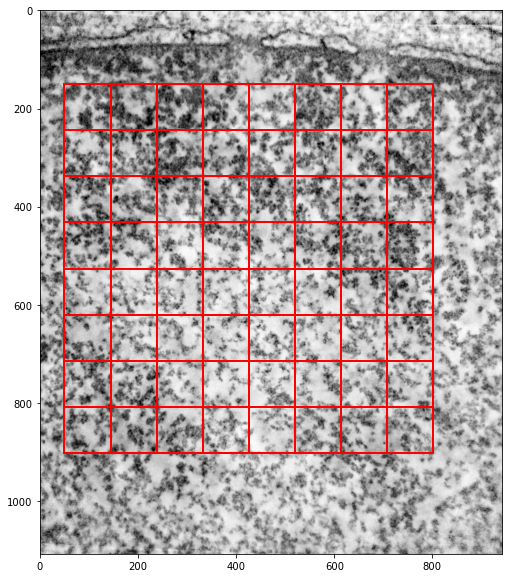

In [4]:
from matplotlib.patches import Rectangle

## plot cuts for verification

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(chromemt_img[0], cmap='gray')

for cut_start in cut_starts:
    rec = Rectangle(cut_start[:0:-1], tile_size, tile_size, fill=None, color='red', lw=2)
    ax.add_artist(rec)

In [5]:
patches = []
masks = []
cvcs = []

import tqdm
from concurrent.futures import ThreadPoolExecutor

## to segment whole image first and then just cut masks, use cut_from_existing_seg instead of cut_and_seg
# mask_whole = segment_like_paper(chromemt_img)
# def cut_from_exisitng_seg(cut_start):
#     patch = chromemt_img[tuple(slice(c, c+tile_size) for c in cut_start)]
#     mask = mask_whole[tuple(slice(c, c+tile_size) for c in cut_start)]
#     return patch, mask

def cut_and_seg(cut_start):
    patch = chromemt_img[tuple(slice(c, c+tile_size) for c in cut_start)]
    mask = segment_like_paper(patch)
    return patch, mask

futures = []
with ThreadPoolExecutor() as tpe:
    for cut_start in cut_starts:
        futures.append(tpe.submit(cut_and_seg, cut_start))

    for f in tqdm.tqdm(futures):
        patch, mask = f.result()
        cvc = mask.sum() / mask.size
        patches.append(patch)
        masks.append(mask)
        cvcs.append(cvc)

100%|██████████| 64/64 [00:27<00:00,  2.30it/s]


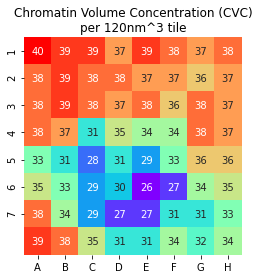

In [6]:
import seaborn as sns

# 'ABC...'
alphabet = ''.join([chr(i) for i in range(ord('A'), ord('A')+26)])

# CVC per tile plot, similar to paper
sns.heatmap(np.reshape(cvcs, n_tiles).squeeze().round(2)*100, annot=True, cmap='rainbow', cbar=False, xticklabels=alphabet[:n_tiles[1]], yticklabels=range(1,n_tiles[1]), square=True)
plt.title('Chromatin Volume Concentration (CVC)\nper 120nm^3 tile');

In [12]:
mask_grid = np.reshape(masks, n_tiles + (tile_size,)*3).squeeze()

a1 = mask_grid[0,0]
f1 = mask_grid[0,4]
d3 = mask_grid[2,3]
d4 = mask_grid[3,3]

mask_cut = mask_grid[5,3]

erosion_radii = np.arange(1, 11)
trace = continuous_erosion_iterative(mask_cut)
d, _ = linear_fit_to_residual_volume(trace, erosion_radii)
d * pixel_size

11.576499572407943

In [32]:
from skimage.io import imsave

tile_grid = np.reshape(patches, n_tiles + (tile_size,)*3).squeeze()
tile_grid.shape

imsave('F:/chromemt_data/fig4_patch_a1.tif', np.expand_dims(tile_grid[0,0], 1), imagej=True)